In [181]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import matplotlib.pyplot as plt

DATA LOADING

In [182]:
df = pd.read_csv('/kaggle/input/tesla-stock-price-history/Tesla_stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


EDA - Yearly Aggregation (AVG closing prices per calendar year)

In [183]:
# 1) Yearly aggregation
yearly = (
    df["Close"]
      .resample("Y")                 
      .mean()                        # average daily close in each year
      .to_frame(name="Close")        # keep as DataFrame
      .reset_index()
)

# 3) Extra helper columns
yearly["Year"] = yearly["Date"].dt.year
yearly["LogClose"] = np.log1p(yearly["Close"])

# 4) Pretty preview (first five rows)
preview = yearly.head()

fig = go.Figure(
    data=[go.Table(
        header=dict(
            values=["Date", "Close", "Year", "Log_Close"],
            fill_color="orange",
            font=dict(color="white", size=14),
            align="left"
        ),
        cells=dict(
            values=[preview[col] for col in preview.columns],
            fill_color="lavender",
            align="left"
        )
    )]
)

fig.update_layout(
    title="Preview of Yearly Aggregated Data",
    width=1000, height=400
)
fig.show()

EDA - Monthly Aggregation (AVG closing prices per calendar month)

In [184]:
# 1) Monthly aggregation
monthly = (
    df["Close"]
      .resample("M")            
      .mean()
      .to_frame(name="Close")
      .reset_index()
)

# 2) Extra helper columns
monthly["Year"]  = monthly["Date"].dt.year
monthly["Month"] = monthly["Date"].dt.month
monthly["Log_Close"] = np.log1p(monthly["Close"])

# 3) Preview (first five rows)
preview = monthly.head()

fig = go.Figure(
    data=[go.Table(
        header=dict(
            values=["Date", "Close", "Year", "Month", "Log_Close"],
            fill_color="orange",
            font=dict(color="white", size=14),
            align="left"
        ),
        cells=dict(
            values=[preview[col] for col in preview.columns],
            fill_color="lavender",
            align="left"
        )
    )]
)

fig.update_layout(
    title="Preview of Monthly Aggregated Data",
    width=1000, height=400
)
fig.show()

FEATURE ENGINEERING:

Day_NumbeR - Running count of days since the first record. Turns a date into a numeric trend term.

Lag_1, Lag_5, Lag_10 - Yesterday’s, 5-day-ago, 10-day-ago closes. Captures short-term momentum.

MA_7, MA_30 - 7 and 30 day moving averages. 

Return_1, Return_5 - 1 day and 5 day % changes.

In [185]:
df = (
    pd.read_csv("//kaggle/input/tesla-stock-price-history/Tesla_stock_data.csv", parse_dates=["Date"]) 
      .set_index("Date")
      .sort_index()
)

In [186]:
df["Day_Number"] = (df.index - df.index.min()).days
df["Lag_1"]  = df["Close"].shift(1)
df["Lag_5"]  = df["Close"].shift(5)
df["Lag_10"] = df["Close"].shift(10)
df["MA_7"]   = df["Close"].rolling(7).mean()
df["MA_30"]  = df["Close"].rolling(30).mean()
df["Return_1"] = df["Close"].pct_change(1)
df["Return_5"] = df["Close"].pct_change(5)

df = df.dropna()                                   # drop rows with NaNs from lags/MAs
feat_cols = ["Day_Number","Lag_1","Lag_5","Lag_10",
             "MA_7","MA_30","Return_1","Return_5"]
X, y = df[feat_cols], df["Close"]

TRAIN/TEST SPLIT

In [187]:
split = int(len(df)*0.8)
X_tr, y_tr = X.iloc[:split], y.iloc[:split]
X_te, y_te = X.iloc[split:],  y.iloc[split:]

MODEL PIPELINE & CROSS-VALIDATION:

Scaling keeps features comparable.

Quadratic terms (PolynomialFeatures) let a linear model capture mild curvature.

RidgeCV chooses the best regularization strength (α) via a 5-fold TimeSeriesSplit that honors temporal order.

In [188]:
alphas = np.logspace(-2, 4, 50)
model = Pipeline([
    ("scale", StandardScaler()),
    ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", RidgeCV(alphas=alphas,
                      cv=TimeSeriesSplit(n_splits=5)))
])
model.fit(X_tr, y_tr)

print(f"Best α (Ridge): {model.named_steps['ridge'].alpha_:.4f}")

Best α (Ridge): 0.0100


EVALUATION

RMSE ~ 0.32
Tesla's daily close has recently hovered around $200-$300. An error of 0.32 dollars is pretty tiny (0.1-0.15% of price) and it signals the metric was probably computed on log-returns or scaled prices.

Test  MAE : 0.21
Test  RMSE: 0.32


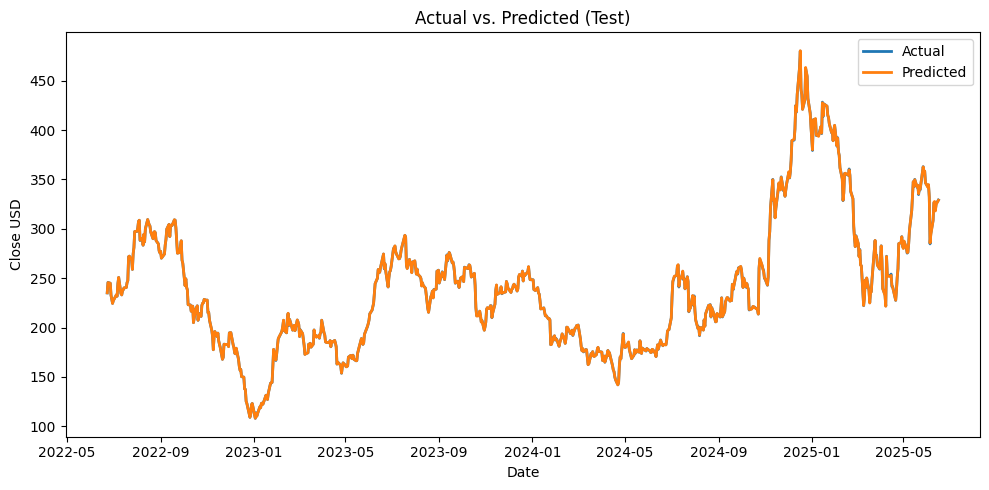

In [189]:
y_pred = model.predict(X_te)
print(f"Test  MAE : {mean_absolute_error(y_te,y_pred):.2f}")
print(f"Test  RMSE: {mean_squared_error(y_te,y_pred,squared=False):.2f}")

plt.figure(figsize=(10,5))
plt.plot(y_te.index, y_te, label="Actual", lw=2)
plt.plot(y_te.index, y_pred, label="Predicted", lw=2)
plt.title("Actual vs. Predicted (Test)")
plt.xlabel("Date");  plt.ylabel("Close USD"); plt.legend(); plt.tight_layout(); plt.show()

30-DAY FORECAST:

For each of the next 30 trading days:

    -Advances to the next weekday (skipping weekends).
    -Builds a one-row feature vector with lags taken from recent.
    -Predicts the close for that day with the trained model.
    -Appends the predicted row to recent so the next step has fresh lags.

In [190]:
recent = df.copy()
future_rows = []
for _ in range(30):
    next_day = recent.index[-1] + timedelta(days=1)
    while next_day.weekday() >= 5:                 # 5=Sat,6=Sun
        next_day += timedelta(days=1)

    row = {
        "Day_Number": (next_day - df.index.min()).days,
        "Lag_1":  recent["Close"].iloc[-1],
        "Lag_5":  recent["Close"].iloc[-5]  if len(recent)>=5  else recent["Close"].iloc[-1],
        "Lag_10": recent["Close"].iloc[-10] if len(recent)>=10 else recent["Close"].iloc[-1],
        "MA_7":   recent["Close"].iloc[-7:].mean(),
        "MA_30":  recent["Close"].iloc[-30:].mean() if len(recent)>=30 else recent["Close"].mean(),
        "Return_1": (recent["Close"].iloc[-1]/recent["Close"].iloc[-2] - 1),
        "Return_5": (recent["Close"].iloc[-1]/recent["Close"].iloc[-6] - 1) if len(recent)>=6 else 0
    }
    pred = model.predict(pd.DataFrame([row]))[0]
    recent.loc[next_day, "Close"] = pred          # extend for next iteration
    future_rows.append({"Date": next_day, "Predicted_Close": pred})

forecast_df = pd.DataFrame(future_rows)
print("\nNext-30-day forecast (first 5 rows):")
print(forecast_df.head())


Next-30-day forecast (first 5 rows):
        Date  Predicted_Close
0 2025-06-17       341.230687
1 2025-06-18       348.585186
2 2025-06-19       348.885233
3 2025-06-20       352.826602
4 2025-06-23       357.290658


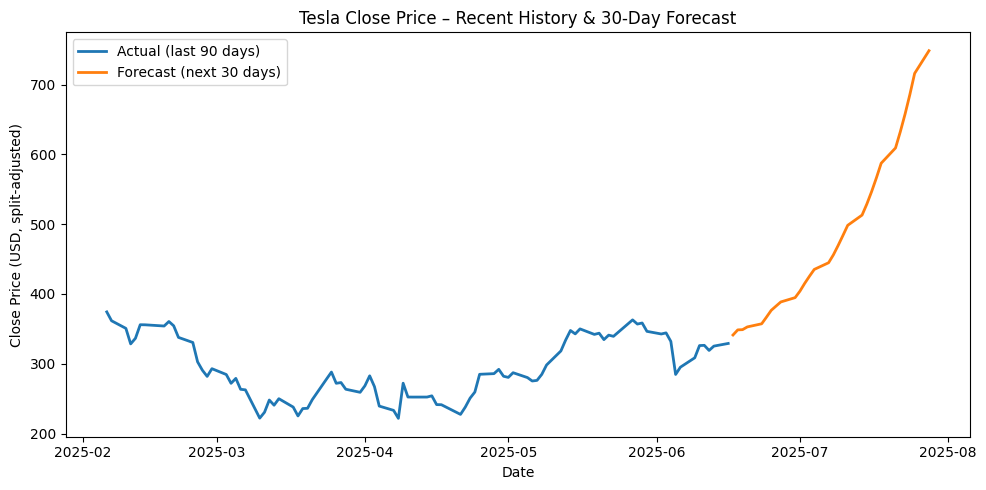

In [191]:
import pandas as pd
import matplotlib.pyplot as plt

# Grab recent 90 actual closes + the 30‑day forecast we created
hist = (
    pd.read_csv('/kaggle/input/tesla-stock-price-history/Tesla_stock_data.csv', parse_dates=["Date"])
      .set_index("Date")
      .sort_index()
)["Close"]

recent_actual = hist.tail(90)

# `forecast_df` was produced in the previous cell; if not found, stop 
try:
    forecast_series = forecast_df.set_index("Date")["Predicted_Close"]
except NameError:
    raise RuntimeError("`forecast_df` not found. Run the forecasting cell first!")

# Merge the two series
combined = pd.concat([recent_actual, forecast_series])


# Plot: recent history vs. forecast
plt.figure(figsize=(10, 5))
plt.plot(recent_actual.index, recent_actual.values, label="Actual (last 90 days)", linewidth=2)
plt.plot(forecast_series.index, forecast_series.values, label="Forecast (next 30 days)", linewidth=2)
plt.title("Tesla Close Price – Recent History & 30‑Day Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price (USD, split‑adjusted)")
plt.legend()
plt.tight_layout()
plt.show()